#### International Conference on Machine Learning (ICML), 2020.

## Frequentist Uncertainty in Recurrent Neural Networks via Blockwise Influence Functions

*Ahmed M. Alaa and Mihaela van der Schaar*

### Experiments on synthetic data (Section 5.1)

Import necessary libraries and initialize model parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
import pickle

from models.rnn import RNN
from models.dprnn import DPRNN
from models.qrnn import QRNN
from utils.make_data import *    
from utils.performance import *   

seq_len      = 10
n_samples    = 1000
INPUT_SIZE   = 1 
EPOCH        = 10
N_STEPS      = 500
BATCH_SIZE   = 100 
MAX_STEPS    = seq_len 
mode         = "RNN"
coverage     = 0.9
n_test       = 5000

params       = dict({"INPUT_SIZE":INPUT_SIZE, 
                     "EPOCH":EPOCH, 
                     "N_STEPS":N_STEPS, 
                     "BATCH_SIZE":BATCH_SIZE, 
                     "MAX_STEPS":MAX_STEPS, 
                     "mode":mode})

Function to train an RNN model and compute uncertainty intervals

In [16]:
X, Y = create_autoregressive_data(n_samples=n_samples, seq_len=10, noise_profile=[0.1 * k for k in range(10)], mode="time-dependent")

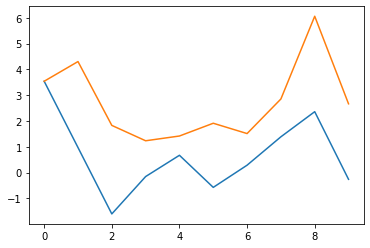

In [26]:
import seaborn as sns
i = np.random.choice(1000)
plt.plot(X[i])
plt.plot(Y[i])

In [14]:
len(Y[1])

6

In [27]:
X_m = 1
X_v = 2
n_features = 1
memory_factor = 0.9

X = [np.random.normal(X_m, X_v, (seq_len, n_features)) for _ in
         range(n_samples)]
w = np.array([memory_factor ** k for k in range(seq_len)])

In [29]:
w

array([1.        , 0.9       , 0.81      , 0.729     , 0.6561    ,
       0.59049   , 0.531441  , 0.4782969 , 0.43046721, 0.38742049])

In [31]:
x = X[1]
np.array([np.sum(x[0:k+1] * np.flip(w[0:k+1]).reshape(-1, 1)) for k in
         range(len(x))])

array([0.31003383, 4.28689347, 5.34115713, 5.41375127, 3.29206414,
       0.84221516, 0.37781319, 3.4193173 , 2.42598697, 4.02485835])

In [35]:
k=5
x[0:k+1] * np.flip(w[0:k+1]).reshape(-1, 1)

array([[ 0.18307188],
       [ 2.62955893],
       [ 1.08107274],
       [ 0.49143498],
       [-1.42228081],
       [-2.12064257]])

In [2]:
def train_BJ_RNN(n_samples, noise_profile, seq_len, params):
    
    X, Y            = create_autoregressive_data(n_samples=n_samples, noise_profile=noise_profile,
                                                 seq_len=seq_len, mode="time-dependent")
    RNN_model       = RNN(**params)
    
    RNN_model.fit(X, Y)
    
    RNN_model_      = RNN_uncertainty_wrapper(RNN_model)
    
    return RNN_model_

Function to evaluate confidence intervals under different experimental setups:

In [6]:
def run_synthetic_experiments(exp_mode, params, coverage, seq_len,
                              n_train_seq, n_test_seq, retrain=False):
    
    baselines           = ["BJRNN", "QRNN", "DPRNN"]
    exp_res_dict        = dict({"BJRNN": [], "QRNN": [], "DPRNN": []})
    baseline_results    = dict({"BJRNN": dict({"CI_length": None, "Errors": None,  "Coverages": None, }), 
                                "QRNN": dict({"CI_length": None, "Errors": None,  "Coverages": None, }), 
                                "DPRNN": dict({"CI_length": None, "Errors": None,  "Coverages": None, })})
    
    if exp_mode=="2":
        
        n_samples_          = [10, 100, 1000]
        noise_var_          = 0.2
        
        if retrain:
    
            for n_sample_ in n_samples_:

                exp_results     = collect_synthetic_results(noise_var_, params, coverage=coverage, seq_len=seq_len,
                                                            n_train_seq=n_train_seq, n_test_seq=n_test_seq)

                exp_res_dict["BJRNN"].append(exp_results["BJRNN"])
                exp_res_dict["QRNN"].append(exp_results["QRNN"])
                exp_res_dict["DPRNN"].append(exp_results["DPRNN"])
        else:
            
            infile              = open('saved_models/Experiment_2_result','rb')
            exp_res_dict        = pickle.load(infile)
            
    elif exp_mode=="1":
            
        noise_vars          = [0.1 * k for k in range(9)]    
        
        if retrain:
            
            for noise_var in noise_vars:

                exp_results   = collect_synthetic_results(noise_var, params, coverage=coverage, seq_len=seq_len,
                                                          n_train_seq=n_samples, n_test_seq=n_test)

                exp_res_dict["BJRNN"].append(exp_results["BJRNN"])
                exp_res_dict["QRNN"].append(exp_results["QRNN"])
                exp_res_dict["DPRNN"].append(exp_results["DPRNN"])
        
        else:
            
            infile              = open('saved_models/Experiment_1_result','rb')
            exp_res_dict        = pickle.load(infile)
        
        
    for baseline in baselines:
        
        baseline_results[baseline]["CI_length"] = [exp_res_dict[baseline][k][0]["CI length"] for k in range(len(exp_res_dict[baseline]))]
        baseline_results[baseline]["Errors"]    = [np.mean(np.concatenate(exp_res_dict[baseline][k][0]["Errors"])) for k in range(len(exp_res_dict[baseline]))]
        baseline_results[baseline]["Coverages"] = BJRNN_coverages = [exp_res_dict[baseline][k][0]["Coverage"] for k in range(len(exp_res_dict[baseline]))]
    
    return baseline_results

In [ ]:
baseline_results = run_synthetic_experiments(exp_mode="1", params=params, coverage=coverage, seq_len=seq_len,
                                             n_train_seq=n_samples, n_test_seq=n_test, retrain=True)

In [ ]:
plt.figure(figsize=(6, 5), edgecolor="black")

plt.plot([1, 2, 3], baseline_results["BJRNN"]["CI_length"], linewidth=3, 
         linestyle="--", marker=".", color="b", label="BJ-RNN") 

plt.plot([1, 2, 3], baseline_results["QRNN"]["CI_length"], linewidth=3, marker=".",
         color="r", label="MQ-RNN")

plt.plot([1, 2, 3], baseline_results["DPRNN"]["CI_length"], linewidth=3, marker=".",
         color="g", label="DP-RNN")

plt.xlabel(r"Noise Level $\sigma$", labelpad=11, fontsize=16, fontweight="bold")
plt.ylabel("Length of Confidence Intervals", labelpad=11, fontsize=16, fontweight="bold")

plt.legend(loc="upper left", fontsize=14, ncol=1)

plt.tick_params(labelsize=14)
plt.rc('axes', edgecolor='dimgrey')

plt.tight_layout()
plt.savefig("figures/BJRNN_synth_Fig1.png", dpi=5000)

In [ ]:
plt.figure(figsize=(6, 5), edgecolor="black")

plt.plot([1, 2, 3], baseline_results["BJRNN"]["Coverages"], linewidth=3, 
         linestyle="--", marker=".", color="b", label="BJ-RNN") 

plt.plot([1, 2, 3], baseline_results["QRNN"]["Coverages"], linewidth=3, marker=".",
         color="r", label="MQ-RNN")

plt.plot([1, 2, 3], baseline_results["DPRNN"]["Coverages"], linewidth=3, marker=".",
         color="g", label="DP-RNN")

plt.xlabel(r"Noise Level $\sigma$", labelpad=11, fontsize=16, fontweight="bold")
plt.ylabel("Achieved coverage", labelpad=11, fontsize=16, fontweight="bold")

plt.legend(loc="upper left", fontsize=14, ncol=1)

plt.tick_params(labelsize=14)
plt.rc('axes', edgecolor='dimgrey')

plt.tight_layout()
plt.savefig("figures/BJRNN_synth_Fig2.png", dpi=5000)

In [4]:
baseline_results = run_synthetic_experiments(exp_mode="2", params=params, coverage=coverage, seq_len=seq_len,
                                             n_train_seq=n_samples, n_test_seq=n_test, retrain=False)

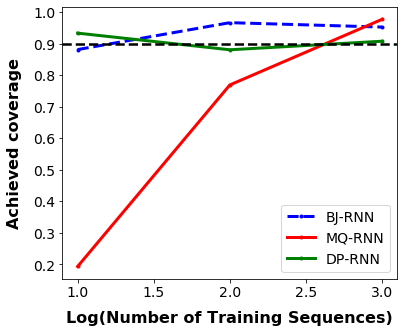

In [5]:
plt.figure(figsize=(6, 5), edgecolor="black")

plt.plot([1, 2, 3], baseline_results["BJRNN"]["Coverages"], linewidth=3, 
         linestyle="--", marker=".", color="b", label="BJ-RNN") 

plt.plot([1, 2, 3], baseline_results["QRNN"]["Coverages"], linewidth=3, marker=".",
         color="r", label="MQ-RNN")

plt.plot([1, 2, 3], baseline_results["DPRNN"]["Coverages"], linewidth=3, marker=".",
         color="g", label="DP-RNN")


plt.axhline(y=.9, linestyle="--", linewidth=2.5, color="black")

plt.xlabel(r"Log(Number of Training Sequences)", labelpad=11, fontsize=16, fontweight="bold")
plt.ylabel("Achieved coverage", labelpad=11, fontsize=16, fontweight="bold")

plt.legend(loc="lower right", fontsize=14, ncol=1)

plt.tick_params(labelsize=14)
plt.rc('axes', edgecolor='dimgrey')

plt.tight_layout()
plt.savefig("figures/BJRNN_synth_Fig3.png", dpi=5000)